### Import Required Libraries

In [29]:
import os

# Data handling and preprocessing
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Model and evaluation
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

# Visualization (optional, but helpful for diagnostics)
import matplotlib.pyplot as plt
import seaborn as sns

# Logging for debugging
import logging

# Set up logging (only once)
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

### Load Data & Select Features (Fold-Change Only)

In [30]:
import pandas as pd
import os
import logging

# Configure logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# File paths
file_paths = {
    "fold_change": "../results/fold_change_results.csv",
    "processed_data": "../processed_data/miRNA_stage_subtype.csv"
}

# Function to load Fold-Change selected features
def load_fold_change_features(file_path, num_features=10):
    if os.path.exists(file_path):
        fc_data = pd.read_csv(file_path)

        # Ensure the required column exists
        if "log2_fold_change" in fc_data.columns and "Unnamed: 0" in fc_data.columns:
            selected_features = fc_data.nlargest(num_features, "log2_fold_change")["Unnamed: 0"].tolist()
            logging.info(f"Loaded top {num_features} Fold-Change features.")
            return selected_features
        else:
            raise ValueError(f"Expected columns not found in {file_path}. Ensure 'log2_fold_change' and 'Unnamed: 0' exist.")
    else:
        raise FileNotFoundError(f"Fold-Change feature selection file not found: {file_path}")

# Load processed data
if os.path.exists(file_paths["processed_data"]):
    processed_data = pd.read_csv(file_paths["processed_data"])
else:
    raise FileNotFoundError(f"Processed data file missing: {file_paths['processed_data']}")

# Select top Fold-Change features
num_features_to_select = 500  # Change as needed
top_features = load_fold_change_features(file_paths["fold_change"], num_features=num_features_to_select)

# Ensure only valid miRNA features are selected (remove metadata like 'stage' and 'subtype' if present)
filtered_features = [feature for feature in top_features if feature.startswith("hsa-mir-")]

# Ensure the selected miRNAs are in the processed dataset
available_features = [feature for feature in filtered_features if feature in processed_data.columns]

# Final Check: Ensure count matches actual miRNAs displayed
logging.info(f"Total valid miRNAs used in classification: {len(available_features)}")

# Display selected miRNAs
print("\nSelected miRNAs for Classification:")
for i, miRNA in enumerate(available_features, 1):
    print(f"{i}. {miRNA}")

# Save cleaned miRNAs to a new CSV file
cleaned_miRNAs_df = pd.DataFrame(available_features, columns=["Selected_miRNAs"])
cleaned_miRNAs_df.to_csv("../results/cleaned_fold_change_miRNAs.csv", index=False)

print("\nProcessing complete. Selected features saved.")

2025-02-09 10:05:50,851 - INFO - Loaded top 500 Fold-Change features.
2025-02-09 10:05:50,852 - INFO - Total valid miRNAs used in classification: 498



Selected miRNAs for Classification:
1. hsa-mir-518f
2. hsa-mir-520e
3. hsa-mir-520d
4. hsa-mir-1283-2
5. hsa-mir-520h
6. hsa-mir-523
7. hsa-mir-519d
8. hsa-mir-515-2
9. hsa-mir-524
10. hsa-mir-521-2
11. hsa-mir-3927
12. hsa-mir-448
13. hsa-mir-4487
14. hsa-mir-526a-2
15. hsa-mir-4678
16. hsa-mir-519e
17. hsa-mir-3689b
18. hsa-mir-518d
19. hsa-mir-5589
20. hsa-mir-3125
21. hsa-mir-1264
22. hsa-mir-3688-1
23. hsa-mir-4651
24. hsa-mir-3688-2
25. hsa-mir-1303
26. hsa-mir-4436b-2
27. hsa-mir-4739
28. hsa-mir-520a
29. hsa-mir-4735
30. hsa-mir-3929
31. hsa-mir-4505
32. hsa-mir-4512
33. hsa-mir-6811
34. hsa-mir-4466
35. hsa-mir-4653
36. hsa-mir-3938
37. hsa-mir-1285-1
38. hsa-mir-4451
39. hsa-mir-4701
40. hsa-mir-510
41. hsa-mir-3132
42. hsa-mir-2117
43. hsa-mir-890
44. hsa-mir-3133
45. hsa-mir-4679-1
46. hsa-mir-3659
47. hsa-mir-6785
48. hsa-mir-499b
49. hsa-mir-4776-2
50. hsa-mir-4671
51. hsa-mir-7151
52. hsa-mir-6791
53. hsa-mir-4427
54. hsa-mir-4776-1
55. hsa-mir-4498
56. hsa-mir-6862-1
5

### Process Features & Labels for Multi-Output Classification (Fold-Change Only)

In [31]:
import pandas as pd
import numpy as np
import logging
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Remove rare cases from dataset before train-test split
rare_cases = [(3, 4), (4, 2)]  # (stage, subtype) pairs to remove

# Create a mask to filter out rare cases
filtered_data = processed_data[~processed_data.set_index(["stage", "subtype"]).index.isin(rare_cases)].copy()

# Remove subtype 4 before splitting (since it only has 1 sample)
filtered_data = filtered_data[filtered_data["subtype"] != 4]

# Ensure Diagnosis column is also updated after filtering
filtered_data["diagnosis"] = filtered_data["subtype"].apply(lambda x: 0 if x == 0 else 1)

# Extract features and target labels again
expression_values = filtered_data[top_features]

# Train-Test Split for Diagnosis Model (Healthy vs. Cancer)
X_train_diagnosis, X_test_diagnosis, y_train_diagnosis, y_test_diagnosis = train_test_split(
    expression_values, filtered_data["diagnosis"], test_size=0.2, random_state=42, stratify=filtered_data["diagnosis"]
)

# Train-Test Split for Stage & Subtype (Only Cancer Patients)
cancer_only = filtered_data["diagnosis"] == 1  # Filter out healthy cases
X_cancer = expression_values[cancer_only]
y_cancer = filtered_data[cancer_only][["stage", "subtype"]]

# Verify updated class distribution
print("\nUpdated class distribution for 'subtype':")
print(y_cancer["subtype"].value_counts())

# Check class distribution before stratifying
print("\nClass distribution in cancer dataset before splitting:")
print(y_cancer.value_counts())

# Check if all classes have at least 2 samples
min_class_size = y_cancer.apply(pd.Series.value_counts).min().min()

if min_class_size < 2:
    print("\nSome classes have too few samples for stratified splitting. Using random split instead.")
    stratify_option = None
else:
    stratify_option = y_cancer

# Define y for consistency
y = y_cancer  # Ensures `y_test` and `y_train` exist later

X_train_cancer, X_test_cancer, y_train_cancer, y_test_cancer = train_test_split(
    X_cancer, y_cancer, test_size=0.2, random_state=42, stratify=stratify_option
)

# Scale features AFTER train-test split
scaler = StandardScaler()
X_train_diagnosis = scaler.fit_transform(X_train_diagnosis)
X_test_diagnosis = scaler.transform(X_test_diagnosis)

X_train_cancer = scaler.fit_transform(X_train_cancer)
X_test_cancer = scaler.transform(X_test_cancer)

# Log updated class distributions
print("\nUpdated Train-Test Split Information:")
print(f"Diagnosis Model - Training set: {X_train_diagnosis.shape}, Testing set: {X_test_diagnosis.shape}")
print(f"Stage & Subtype Model - Training set: {X_train_cancer.shape}, Testing set: {X_test_cancer.shape}")

print("\nUpdated Training set class distribution (Diagnosis):")
print(y_train_diagnosis.value_counts())

print("\nUpdated Training set class distribution (Stage & Subtype):")
print(y_train_cancer.value_counts())

print("\nUpdated Testing set class distribution (Diagnosis):")
print(y_test_diagnosis.value_counts())

print("\nUpdated Testing set class distribution (Stage & Subtype):")
print(y_test_cancer.value_counts())


Updated class distribution for 'subtype':
subtype
1    560
2    512
Name: count, dtype: int64

Class distribution in cancer dataset before splitting:
stage  subtype
1      1          312
       2          254
2      2          174
       1          134
3      1           90
       2           84
4      1           24
Name: count, dtype: int64

Updated Train-Test Split Information:
Diagnosis Model - Training set: (866, 500), Testing set: (217, 500)
Stage & Subtype Model - Training set: (857, 500), Testing set: (215, 500)

Updated Training set class distribution (Diagnosis):
diagnosis
1    857
0      9
Name: count, dtype: int64

Updated Training set class distribution (Stage & Subtype):
stage  subtype
1      1          250
       2          203
2      2          139
       1          107
3      1           72
       2           67
4      1           19
Name: count, dtype: int64

Updated Testing set class distribution (Diagnosis):
diagnosis
1    215
0      2
Name: count, dtype: int64

Up

### Train-Test Split & Feature Scaling (Fold-Change Only)

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Validate Selected Features
print("\nInitial data check:")
print("Top features:", top_features)
print("Number of top features:", len(top_features))

top_features = [feature for feature in top_features if feature in filtered_data.columns]
if not top_features:
    raise ValueError("No matching features found in processed data for the selected feature set.")

# Filter and Prepare Data
expression_values = filtered_data[top_features]

print("\nData shapes before handling missing values:")
print("Expression values shape:", expression_values.shape)

# Convert to numeric and handle missing values
expression_values = expression_values.apply(pd.to_numeric, errors='coerce')

# Remove samples with missing values
valid_indices = ~(expression_values.isnull().any(axis=1))
expression_values = expression_values[valid_indices]
filtered_data = filtered_data.loc[valid_indices]

print("\nData shapes after handling missing values:")
print("Expression values shape:", expression_values.shape)

# SINGLE TRAIN-TEST SPLIT (Applies to ALL Models)
X_train, X_test, y_train, y_test = train_test_split(
    expression_values, filtered_data[["diagnosis", "stage", "subtype"]],
    test_size=0.2, random_state=42, stratify=filtered_data[["diagnosis", "stage", "subtype"]]
)

# Extract labels for each model
y_train_diagnosis, y_test_diagnosis = y_train["diagnosis"], y_test["diagnosis"]
y_train_stage, y_test_stage = y_train["stage"], y_test["stage"]
y_train_subtype, y_test_subtype = y_train["subtype"], y_test["subtype"]

# SCALE FEATURES (Same for all models)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Log updated class distributions
print("\nUpdated Train-Test Split Information:")
print(f"Training set: {X_train.shape}, Testing set: {X_test.shape}")

print("\nTraining set class distribution (Diagnosis):")
print(y_train_diagnosis.value_counts())

print("\nTraining set class distribution (Stage):")
print(y_train_stage.value_counts())

print("\nTraining set class distribution (Subtype):")
print(y_train_subtype.value_counts())

print("\nTesting set class distribution (Diagnosis):")
print(y_test_diagnosis.value_counts())

print("\nTesting set class distribution (Stage):")
print(y_test_stage.value_counts())

print("\nTesting set class distribution (Subtype):")
print(y_test_subtype.value_counts())

# Save Scaler for Later Use
scaler_info = {
    'scaler': scaler,
    'feature_names': top_features
}


Initial data check:
Top features: ['hsa-mir-518f', 'stage', 'subtype', 'hsa-mir-520e', 'hsa-mir-520d', 'hsa-mir-1283-2', 'hsa-mir-520h', 'hsa-mir-523', 'hsa-mir-519d', 'hsa-mir-515-2', 'hsa-mir-524', 'hsa-mir-521-2', 'hsa-mir-3927', 'hsa-mir-448', 'hsa-mir-4487', 'hsa-mir-526a-2', 'hsa-mir-4678', 'hsa-mir-519e', 'hsa-mir-3689b', 'hsa-mir-518d', 'hsa-mir-5589', 'hsa-mir-3125', 'hsa-mir-1264', 'hsa-mir-3688-1', 'hsa-mir-4651', 'hsa-mir-3688-2', 'hsa-mir-1303', 'hsa-mir-4436b-2', 'hsa-mir-4739', 'hsa-mir-520a', 'hsa-mir-4735', 'hsa-mir-3929', 'hsa-mir-4505', 'hsa-mir-4512', 'hsa-mir-6811', 'hsa-mir-4466', 'hsa-mir-4653', 'hsa-mir-3938', 'hsa-mir-1285-1', 'hsa-mir-4451', 'hsa-mir-4701', 'hsa-mir-510', 'hsa-mir-3132', 'hsa-mir-2117', 'hsa-mir-890', 'hsa-mir-3133', 'hsa-mir-4679-1', 'hsa-mir-3659', 'hsa-mir-6785', 'hsa-mir-499b', 'hsa-mir-4776-2', 'hsa-mir-4671', 'hsa-mir-7151', 'hsa-mir-6791', 'hsa-mir-4427', 'hsa-mir-4776-1', 'hsa-mir-4498', 'hsa-mir-6862-1', 'hsa-mir-4425', 'hsa-mir-4520

### Train Multi-Output SVM Model (Fold-Change Only)

In [38]:
import warnings
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Suppress warnings
warnings.simplefilter("ignore")

# Define Hyperparameter Grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 0.1, 1, 10],
    'kernel': ['rbf']
}

# Train Diagnosis SVM
print("\nTraining Diagnosis SVM...")
svm_diagnosis = SVC(class_weight="balanced", random_state=42)
grid_diagnosis = GridSearchCV(svm_diagnosis, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
grid_diagnosis.fit(X_train_diagnosis, y_train_diagnosis)

best_svm_diagnosis = grid_diagnosis.best_estimator_
y_pred_diagnosis = best_svm_diagnosis.predict(X_test_diagnosis)

print("\nBest SVM Hyperparameters (Diagnosis):", grid_diagnosis.best_params_)
print("\nClassification Report for Diagnosis:\n", classification_report(y_test_diagnosis, y_pred_diagnosis, zero_division=0))

# Train Stage SVM
print("\nTraining Stage SVM...")
svm_stage = SVC(class_weight="balanced", random_state=42)
grid_stage = GridSearchCV(svm_stage, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
grid_stage.fit(X_train_cancer, y_train_cancer["stage"])

best_svm_stage = grid_stage.best_estimator_
y_pred_stage = best_svm_stage.predict(X_test_cancer)

print("\nBest SVM Hyperparameters (Stage):", grid_stage.best_params_)
print("\nClassification Report for Stage:\n", classification_report(y_test_cancer["stage"], y_pred_stage, zero_division=0))

# Train Subtype SVM
print("\nTraining Subtype SVM...")
svm_subtype = SVC(class_weight="balanced", random_state=42)
grid_subtype = GridSearchCV(svm_subtype, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
grid_subtype.fit(X_train_cancer, y_train_cancer["subtype"])

best_svm_subtype = grid_subtype.best_estimator_
y_pred_subtype = best_svm_subtype.predict(X_test_cancer)

print("\nBest SVM Hyperparameters (Subtype):", grid_subtype.best_params_)
print("\nClassification Report for Subtype:\n", classification_report(y_test_cancer["subtype"], y_pred_subtype, zero_division=0))


Training Diagnosis SVM...

Best SVM Hyperparameters (Diagnosis): {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}

Classification Report for Diagnosis:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.99      1.00      1.00       215

    accuracy                           0.99       217
   macro avg       0.50      0.50      0.50       217
weighted avg       0.98      0.99      0.99       217


Training Stage SVM...

Best SVM Hyperparameters (Stage): {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}

Classification Report for Stage:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       0.84      0.99      0.91       113
           2       0.83      0.73      0.78        62
           3       0.86      0.69      0.76        35
           4       0.00      0.00      0.00         5

    accuracy                           0.84       217
   macro 

### Evaluate SVM Model (Fold-Change)

Checking y_test...
     diagnosis  stage  subtype
727          1      2        1
305          1      2        1
955          1      2        2
736          1      2        2
532          1      1        1

-------------------- SVM (Fold-Change) Results --------------------

Stage Classification:
Accuracy: 0.8433

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       0.84      0.99      0.91       113
           2       0.83      0.73      0.78        62
           3       0.86      0.69      0.76        35
           4       0.00      0.00      0.00         5

    accuracy                           0.84       217
   macro avg       0.71      0.68      0.69       217
weighted avg       0.82      0.84      0.83       217


Confusion Matrix:
 [[  2   0   0   0   0]
 [  0 112   1   0   0]
 [  0  16  45   1   0]
 [  0   4   7  24   0]
 [  0   1   1   3   0]]

Subtype Classification:
Accuracy: 0

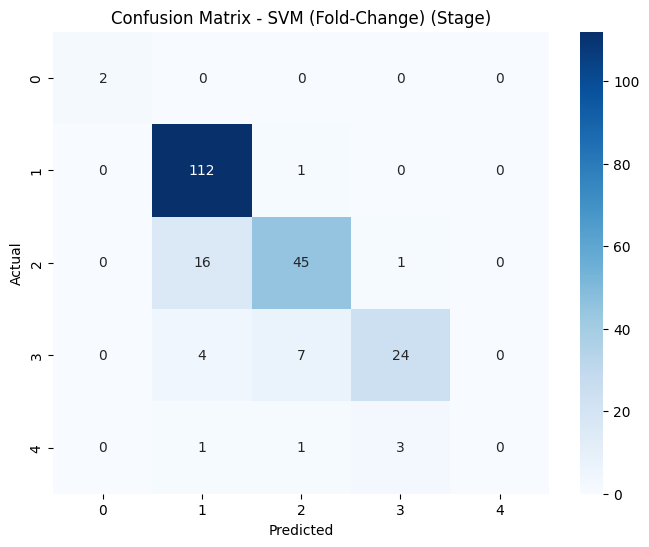


Subtype Confusion Matrix saved to ../results/svm_fold_change/svm_fold_change_subtype_confusion_matrix.png


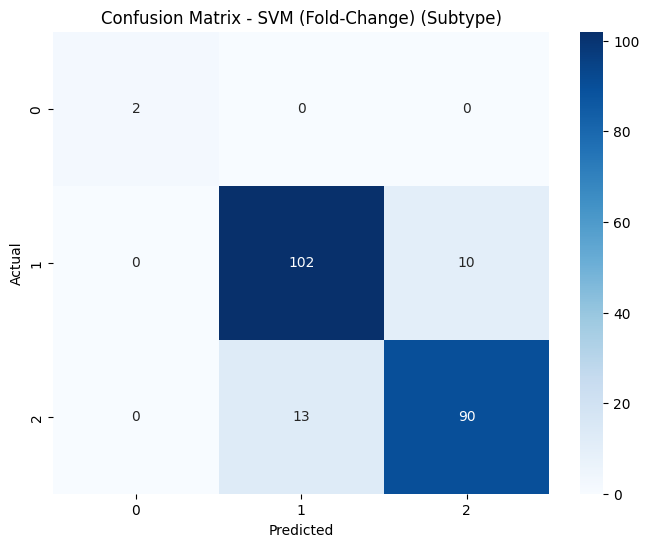

2025-02-09 10:19:41,195 - INFO - 
Model Evaluation Completed!
2025-02-09 10:19:41,196 - INFO - Stage Accuracy: 0.8433
2025-02-09 10:19:41,196 - INFO - Subtype Accuracy: 0.8940


In [42]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import logging

# Logging setup
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

def evaluate_multioutput_model(y_test, y_pred, model_name="SVM (Fold-Change)", save_dir="../results/svm_fold_change/"):
    """
    Evaluate multi-output model performance for Stage and Subtype separately,
    including classification reports and confusion matrices.
    """
    os.makedirs(save_dir, exist_ok=True)  # Ensure directory exists

    # Convert predictions to DataFrame for easy handling
    y_pred_df = pd.DataFrame(y_pred, columns=["stage", "subtype"], index=y_test.index)

    # Evaluate Stage Classification
    stage_accuracy = accuracy_score(y_test["stage"], y_pred_df["stage"])
    stage_cm = confusion_matrix(y_test["stage"], y_pred_df["stage"])
    stage_report = classification_report(y_test["stage"], y_pred_df["stage"], zero_division=0)

    # Evaluate Subtype Classification
    subtype_accuracy = accuracy_score(y_test["subtype"], y_pred_df["subtype"])
    subtype_cm = confusion_matrix(y_test["subtype"], y_pred_df["subtype"])
    subtype_report = classification_report(y_test["subtype"], y_pred_df["subtype"], zero_division=0)

    print(f"\n{'-'*20} {model_name} Results {'-'*20}")

    print("\nStage Classification:")
    print(f"Accuracy: {stage_accuracy:.4f}")
    print("\nClassification Report:\n", stage_report)
    print("\nConfusion Matrix:\n", stage_cm)

    print("\nSubtype Classification:")
    print(f"Accuracy: {subtype_accuracy:.4f}")
    print("\nClassification Report:\n", subtype_report)
    print("\nConfusion Matrix:\n", subtype_cm)

    # Save Confusion Matrices
    for label, cm, name in [("stage", stage_cm, "Stage"), ("subtype", subtype_cm, "Subtype")]:
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=sorted(y_test[name.lower()].unique()),
                    yticklabels=sorted(y_test[name.lower()].unique()))
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title(f"Confusion Matrix - {model_name} ({name})")

        cm_path = os.path.join(save_dir, f"svm_fold_change_{label}_confusion_matrix.png")
        plt.savefig(cm_path)
        print(f"\n{name} Confusion Matrix saved to {cm_path}")
        plt.show()

    # Log evaluation metrics
    logging.info(f"\nModel Evaluation Completed!")
    logging.info(f"Stage Accuracy: {stage_accuracy:.4f}")
    logging.info(f"Subtype Accuracy: {subtype_accuracy:.4f}")

    # Return metrics as dictionary
    return {
        "stage_accuracy": stage_accuracy,
        "subtype_accuracy": subtype_accuracy,
        "stage_confusion_matrix": stage_cm.tolist(),
        "subtype_confusion_matrix": subtype_cm.tolist(),
        "stage_classification_report": stage_report,
        "subtype_classification_report": subtype_report
    }

# Ensure `y_test` exists before evaluation
print("Checking y_test...")
print(y_test.head())  # Ensure it contains "stage" and "subtype" columns

# Run Evaluation
save_dir = "../results/svm_fold_change/"
metrics = evaluate_multioutput_model(y_test, np.column_stack((y_pred_stage, y_pred_subtype)), 
                                     model_name="SVM (Fold-Change)", save_dir=save_dir)

### Save Everything & Finalize the Pipeline (Fold-Change Only, Updated)

In [43]:
import os
import json
import pandas as pd
import joblib
import logging

# Configure Logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# Define Output Directory
output_dir = "../results/svm_fold_change/"
os.makedirs(output_dir, exist_ok=True)  # Ensure directory exists

# Ensure `y_test` is properly assigned
if "y_test" not in locals():
    raise ValueError("`y_test` is missing. Ensure the variable is correctly assigned before running this block.")

# Save Predictions & Actual Labels
y_pred_df = pd.DataFrame(y_pred, columns=["stage", "subtype"], index=y_test.index)

predictions_path = os.path.join(output_dir, "svm_fold_change_predictions.csv")
y_pred_df.to_csv(predictions_path, index=False)
logging.info(f"Predictions saved to {predictions_path}")
print(f"Predictions saved to {predictions_path}")

actual_labels_path = os.path.join(output_dir, "svm_fold_change_actual_labels.csv")
y_test.to_csv(actual_labels_path, index=False)
logging.info(f"Actual labels saved to {actual_labels_path}")
print(f"Actual labels saved to {actual_labels_path}")

# Save Experiment Metadata
metadata = {
    "stage_hyperparameters": grid_stage.best_params_ if "grid_stage" in locals() else "N/A",
    "subtype_hyperparameters": grid_subtype.best_params_ if "grid_subtype" in locals() else "N/A",
    "stage_accuracy": metrics["stage_accuracy"] if "metrics" in locals() else "N/A",
    "subtype_accuracy": metrics["subtype_accuracy"] if "metrics" in locals() else "N/A",
    "stage_confusion_matrix": metrics["stage_confusion_matrix"] if "metrics" in locals() else "N/A",
    "subtype_confusion_matrix": metrics["subtype_confusion_matrix"] if "metrics" in locals() else "N/A",
    "train_set_size": X_train.shape[0] if "X_train" in locals() else "N/A",
    "test_set_size": X_test.shape[0] if "X_test" in locals() else "N/A"
}

metadata_path = os.path.join(output_dir, "svm_fold_change_metadata.json")
with open(metadata_path, "w") as f:
    json.dump(metadata, f, indent=4)
logging.info(f"Metadata saved to {metadata_path}")
print(f"Metadata saved to {metadata_path}")

# Save Separate Models for Stage & Subtype
if "best_svm_stage" in locals():
    model_stage_path = os.path.join(output_dir, "svm_fold_change_stage_model.pkl")
    joblib.dump(best_svm_stage, model_stage_path)
    logging.info(f"Stage model saved to {model_stage_path}")
    print(f"Stage model saved to {model_stage_path}")
else:
    logging.warning("`best_svm_stage` is missing. The model was not saved.")

if "best_svm_subtype" in locals():
    model_subtype_path = os.path.join(output_dir, "svm_fold_change_subtype_model.pkl")
    joblib.dump(best_svm_subtype, model_subtype_path)
    logging.info(f"Subtype model saved to {model_subtype_path}")
    print(f"Subtype model saved to {model_subtype_path}")
else:
    logging.warning("`best_svm_subtype` is missing. The model was not saved.")

print("\nAll results successfully saved. The Fold-Change baseline SVM pipeline is complete.")


2025-02-09 10:19:55,925 - INFO - Predictions saved to ../results/svm_fold_change/svm_fold_change_predictions.csv
2025-02-09 10:19:55,927 - INFO - Actual labels saved to ../results/svm_fold_change/svm_fold_change_actual_labels.csv
2025-02-09 10:19:55,929 - INFO - Metadata saved to ../results/svm_fold_change/svm_fold_change_metadata.json
2025-02-09 10:19:55,933 - INFO - Stage model saved to ../results/svm_fold_change/svm_fold_change_stage_model.pkl
2025-02-09 10:19:55,937 - INFO - Subtype model saved to ../results/svm_fold_change/svm_fold_change_subtype_model.pkl


Predictions saved to ../results/svm_fold_change/svm_fold_change_predictions.csv
Actual labels saved to ../results/svm_fold_change/svm_fold_change_actual_labels.csv
Metadata saved to ../results/svm_fold_change/svm_fold_change_metadata.json
Stage model saved to ../results/svm_fold_change/svm_fold_change_stage_model.pkl
Subtype model saved to ../results/svm_fold_change/svm_fold_change_subtype_model.pkl

All results successfully saved. The Fold-Change baseline SVM pipeline is complete.
